<a href="https://colab.research.google.com/github/chetan-parthiban/SFA/blob/master/SFA_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SFA For Monkey Vocalization Identification

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import soundfile as sf 
import pyfilterbank.gammatone as g
import scipy.ndimage.filters as filt
from sklearn import svm
from sklearn.linear_model import Perceptron
from tqdm import tqdm

import SFA_Tools.SFA_Sets as s
from SFA_Tools.SFA_Func import *

## Initialize Variables

In [0]:
## Files for vocalizations and noise
load_noise = True
noise = None
noiselen = 100000
vocal_files = ['coo.WAV','grunt.WAV','AG493B.WAV','CS1E54.WAV']
noise_file = 'Matlab_SoundTextureSynth/Output_Folder/Bubbling_water_10111010100.wav'
num_vocals = len(vocal_files)

## Parameters for vocalization and noise preprocessing
signal_to_noise_ratio = 50
gfb = g.GammatoneFilterbank(order=1, density = 1.0, startband = -21, endband = 21, normfreq = 2200)
plot_gammatone_transformed = False
plot_temporal_filters = False
plot_temporal_transformed = True

## Parameters for training data
num_samples = num_vocals * 1
gaps = True
min_gap = 25
max_gap = 100
apply_noise = True

## Parameters for testing data
test_noise = True
plot_test = True
plot_features = True

classifier_baseline = Perceptron(max_iter = 1000, tol = 0.001)
classifier_SFA = Perceptron(max_iter = 1000, tol = 0.001)
classifier_features = 2

## Load In Files Containing Vocalizations And Noise

In [0]:
vocalizations = get_data(vocal_files)
print('Vocalizations Loaded...')

if(load_noise):
    noise, _ = sf.read(noise_file)

print('Noises loaded...')
print('Ready for preprocessing.')

Vocalizations Loaded...
Noises loaded...
Ready for preprocessing.


## Preprocess Vocalizations And Noise

### Adjusting Noise For Signal To Noise Ratio

In [0]:
noise = scale_noise(vocalizations,noise,signal_to_noise_ratio)
noise = noise[:noiselen]
print('Noise Scaled...')
print('Ready For Gammatone Transform')

Noise Scaled...
Ready For Gammatone Transform


### Apply Gammatone Transform 

In [0]:
vocals_transformed = gamma_transform_list(vocalizations, gfb)
print('Vocalizations Transformed...')

noise_transformed = gamma_transform(noise, gfb)
print('Noise Transformed...')

if(plot_gammatone_transformed):
    for i,vocal in enumerate(vocals_transformed):
        plot_input(vocal, vocal_files[i])
    plot_input(noise_transformed, 'Noise')
    
print('Ready For Temporal Filters')

100%|██████████| 4/4 [00:00<00:00, 16.93it/s]


Vocalizations Transformed...
Noise Transformed...
Ready For Temporal Filters


### Apply Temporal Filters

100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Vocals Temporally Filtered...
Noise Temporraly Filtered


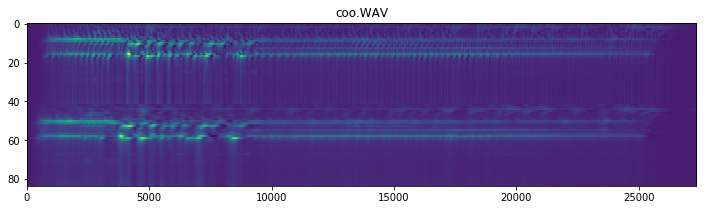

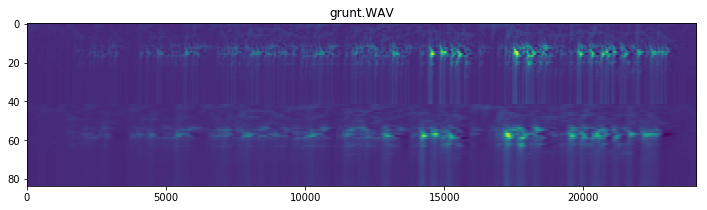

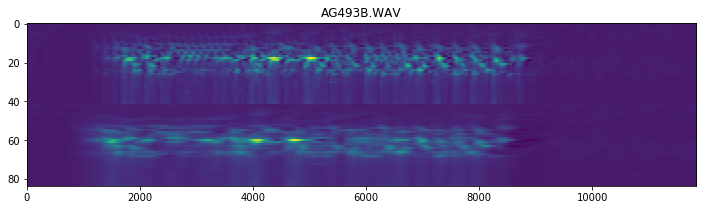

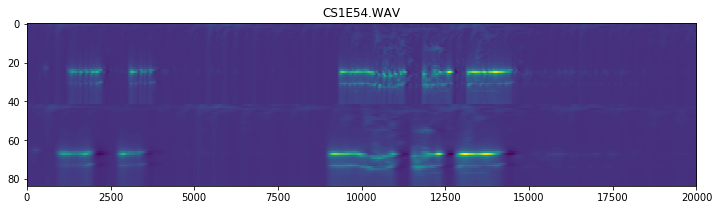

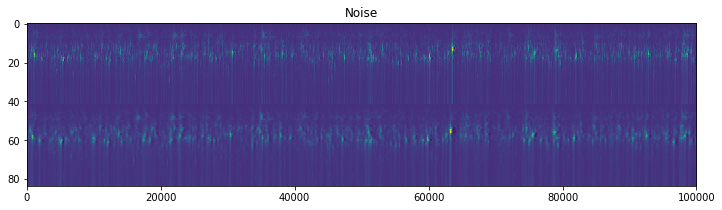

Ready For SFA


In [0]:
tFilter = temporalFilter()
tFilter2 = np.repeat(tFilter,3)/3
tFilters = [tFilter, tFilter2]

if(plot_temporal_filters):
    plt.plot(tFilter)
    plt.plot(tFilter2)
    plt.show()

vocals_temporal_transformed = temporal_transform_list(vocals_transformed,tFilters)
print('Vocals Temporally Filtered...')

noise_temporal_transformed = temporal_transform(noise_transformed,tFilters)
print('Noise Temporraly Filtered')

if(plot_temporal_transformed):
    for i,vocal in enumerate(vocals_temporal_transformed):
        plot_input(vocal, vocal_files[i])
    plot_input(noise_temporal_transformed, 'Noise')

print('Ready For SFA')

### Create Training Dataset

In [0]:
samples = np.random.randint(num_vocals, size = num_samples)

training_data = None
initialized = False
for i in tqdm(samples):
    if(not(initialized)):
        training_data = vocals_temporal_transformed[i]
        initialized = True
    else:
        training_data = np.concatenate((training_data, vocals_temporal_transformed[i]),1)
        
    if(gaps):
        training_data = np.concatenate((training_data, np.zeros((training_data.shape[0], np.random.randint(min_gap,max_gap)))),1)     
print('Data arranged...')
if(apply_noise):
    while(noise_temporal_transformed[0].size < training_data[0].size):
        noise_temporal_transformed = np.hstack((noise_temporal_transformed,noise_temporal_transformed))
    training_data = training_data + noise_temporal_transformed[:,0:training_data[0].size]
    print('Applied Noise...')
else:
    print('No Noise Applied...')

print('Ready For SFA')

100%|██████████| 4/4 [00:00<00:00, 18.30it/s]

Data arranged...
Applied Noise...
Ready For SFA


## Train SFA On Data

In [0]:
(mean, variance, data_SS, weights) = getSF(training_data, 'Layer 1')

print('SFA Training Complete')

Layer 1 : Normalization Complete...
Layer 1 : Nonlinear Expansion Complete...
Layer 1 : Sphering Complete...
Layer 1 : Weights Determined...
SFA Training Complete


## Test SFA Results

### Create Test Data

100%|██████████| 4/4 [00:00<00:00, 41.78it/s]

Data arranged...
Applied Noise...


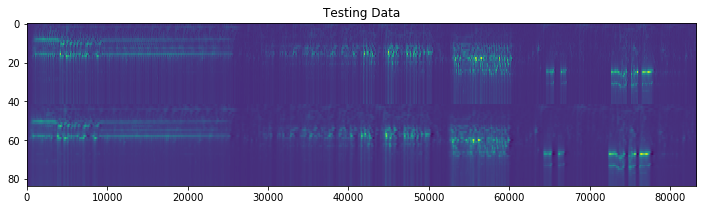

Testing Data Ready


In [0]:
samples = np.arange(num_vocals)

testing_data = None
initialized = False
for i in tqdm(samples):
    if(not(initialized)):
        testing_data = vocals_temporal_transformed[i]
        initialized = True
    else:
        testing_data = np.concatenate((testing_data, vocals_temporal_transformed[i]),1) 
print('Data arranged...')

if(test_noise):
    testing_data = testing_data + noise_temporal_transformed[:,0:testing_data[0].size]
    print('Applied Noise...')
else:
    print('No Noise Applied...')

if(plot_test):
    plot_input(testing_data, 'Testing Data')
print('Testing Data Ready')

### Apply SFA To Test Set

In [0]:
test = testSF(testing_data, 'Layer 1', mean, variance, data_SS, weights)
print('SFA Applied To Test Set')

Layer 1 : Normalization Complete...
Layer 1 : Nonlinear Expansion Complete...
Layer 1 : Sphering Complete...
SFA Applied To Test Set


### Plot SFA Features

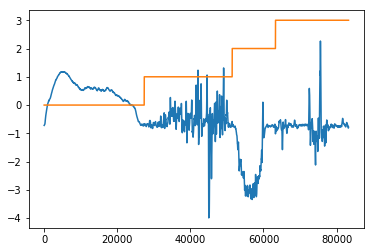

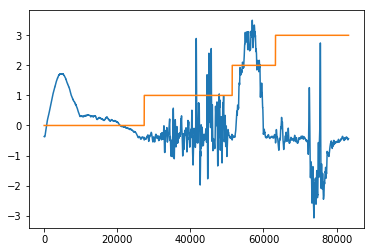

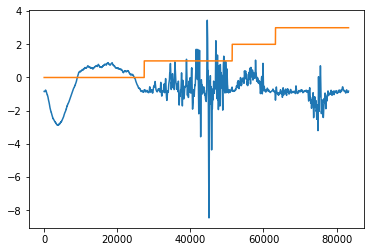

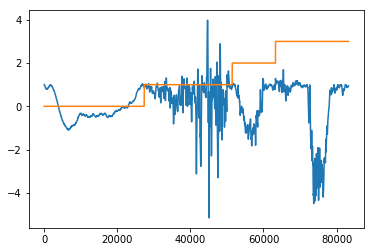

SFA Features Plotted


In [0]:
labels = getlabels(vocals_temporal_transformed)

if(plot_features):
    for i in range(4):
        plt.plot(test[i])
        plt.plot(labels)
        plt.show() 
    print('SFA Features Plotted')
else:
    print('Skipping Feature Plotting')

### Compare SFA With Baseline For Linear Classification

In [0]:
print('SFA Based Classifier with ', classifier_features, ' features')
classifier_SFA.fit(test[:classifier_features].T,labels)
print(classifier_SFA.score(test[:classifier_features].T,labels), '\n')

print('Baseline Classifier with ', classifier_features, ' features')
classifier_baseline.fit(testing_data.T,labels)
print(classifier_baseline.score(testing_data.T,labels))

SFA Based Classifier with  2  features
0.6066629036713224 

Baseline Classifier with  2  features
0.9865973314758548


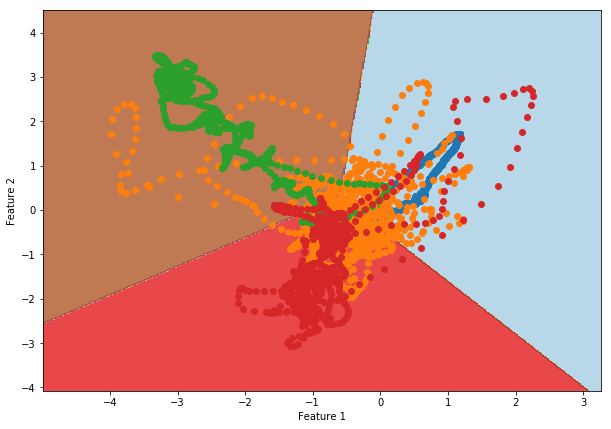

In [0]:
SFAClassifiedPlot(test,classifier_SFA,labels)